Importing required libraries

In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3 as PretrainedModel_inception, preprocess_input as preprocess_input_inception
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

Extracting the dataset of roses and tulips

In [2]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# Download the zip file saved in the Drive 
!pip install -U -q PyDrive

#File ID
zip_id = '1sajk-SXeemD-0JXDoTMezv3hlvoHUi4v'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('roses_and_tulips.zip')

Unzipping .zip file

In [3]:
!unzip -qq -o roses_and_tulips.zip

Making new directories for dividing train and test dataset

In [4]:
# Make appropriate directories 
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/roses
!mkdir data/train/tulips
!mkdir data/test/roses
!mkdir data/test/tulips

Moving first 200 images to train and remaining 100 images to validation for both roses and tulips

In [5]:
!ls roses_and_tulips/roses/*.jpg | head -200 | xargs -I{} mv {} data/train/roses
!ls roses_and_tulips/roses/*.jpg | head -100 | xargs -I{} mv {} data/test/roses
!ls roses_and_tulips/tulips/*.jpg | head -200 | xargs -I{} mv {} data/train/tulips
!ls roses_and_tulips/tulips/*.jpg | head -100 | xargs -I{} mv {} data/test/tulips

train_path = 'data/train'
valid_path = 'data/test'

Setting image size to 150X150 and checking number of images in train and test

In [6]:
IMAGE_SIZE = [150, 150]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print(len(image_files))
print(len(valid_image_files))

# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

400
200
['data/train/tulips', 'data/train/roses']


# VGG16

**Model 1: Perform Transfer Learning with Augmentation**

Instantiating VGG16 pretrained model

In [7]:
# input_shape = dimension of image + 3(3 colored channels - depth of the image)
# weights = use the weights from the VGG16 that were trained on imagenet dataset
# include_top = False (give the weights for stage1 not stage2)
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

# To freeze the weights extracted above from VGG 
# freeze pretrained model weights
ptm.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


Model definition



In [8]:
# map the data into feature vectors
#Stage1
K = len(folders) # number of classes

#Stage2
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

# Model object
# inputs - goes in the pretrained model input
# output - comes out the entire model from stage2
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Creating ImageDataGenerator

In [9]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input  # make sure that the images confirm to VGG16 convolution model(stage1)
)

#Augementation is done only on train dataset but the test dataset should be transformed as per VGG16 stage1 requirements
gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Model compilation and fit

In [10]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
4/4 [==============================] - 27s 3s/step - loss: 3.0729 - accuracy: 0.6850 - val_loss: 2.3196 - val_accuracy: 0.7650
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 2.2388 - accuracy: 0.7775 - val_loss: 1.8788 - val_accuracy: 0.8200
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 1.3792 - accuracy: 0.8475 - val_loss: 1.7374 - val_accuracy: 0.8300
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 1.1153 - accuracy: 0.8800 - val_loss: 1.4468 - val_accuracy: 0.8850
Epoch 5/10
4/4 [==============================] - 5s 2s/step - loss: 0.9846 - accuracy: 0.8950 - val_loss: 1.2848 - val_accuracy: 0.8950
Epoch 6/10
4/4 [==============================] - 6s 1s/step - loss: 0.8031 - accuracy: 0.9200 - val_loss: 1.3517 - val_accuracy: 0.8850
Epoch 7/10
4/4 [==============================] - 5s 2s/step - loss: 0.7105 - accuracy: 0.9175 - val_loss: 1.4096 - val_accuracy: 0.8800
Epoch 8/10
4/4 [========================

Model 1 - Loss plot

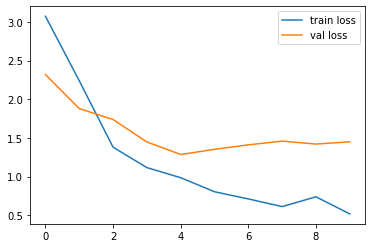

In [11]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model 1 - Accuracy plot

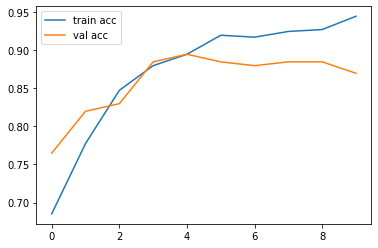

In [12]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**Model 2: Perform Transfer Learning without Augmentation**

Instantiating VGG16 pretrained model

In [13]:
# input_shape = dimension of image + 3(3 colored channels - depth of the image)
# weights = use the weights from the VGG16 that were trained on imagenet dataset
# include_top = False (give the weights for stage1 not stage2)
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

Model definition



In [14]:
# map the data into feature vectors
x = Flatten()(ptm.output)

# Model object
# inputs - goes in the pretrained model input
# output - comes out the entire model from stage2
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

Creating ImageDataGenerator

In [15]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [16]:
# Creating a tabular dataset for all the image features - Take an image run it trhough stage1 and add it to feature vector matrix ony by one
# Each row representas an image in a vector form
# Number of training and testing images
Ntrain = len(image_files) #Gives the number of training images
Nvalid = len(valid_image_files) #Gives the number of test images

# Passing on the random input to know the size required by model
# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]  #Gives number of features per image (flattened dimensionality)

# Initialize with number of features per image
X_train = np.zeros((Ntrain, D)) #Ntrain nuumber of rows, D number of columns
Y_train = np.zeros(Ntrain)   #Ntrain number of rows for target values of each image
X_valid = np.zeros((Nvalid, D)) 
Y_valid = np.zeros(Nvalid)

In [17]:
# populate X_train and Y_train
i = 0  #which sample we are currently populating within the loop
for x, y in train_generator:   #Generate X and y tuples at each step (batch of images not one image) (128 in every batch except last one)
  # get features
  features = model.predict(x)  # predicting on each images of (128 total in batch)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)                  
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features        #Assign the features a 2dimensional array to X_train(128XD)
  Y_train[i:i + sz] = y               #Assign y to y_train (128)
  
  # increment i                      # incrementing by batch size (128)
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
400
breaking now
400


In [18]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
200


In [19]:
#Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

Model compilation and fit

In [20]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

linearmodel.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# fit the model
r = linearmodel.fit(
    X_train2, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid2, Y_valid),
)

Epoch 1/10
4/4 [==============================] - 1s 64ms/step - loss: 0.6887 - accuracy: 0.6225 - val_loss: 0.6079 - val_accuracy: 0.7400
Epoch 2/10
4/4 [==============================] - 0s 15ms/step - loss: 0.2917 - accuracy: 0.8825 - val_loss: 0.5181 - val_accuracy: 0.8050
Epoch 3/10
4/4 [==============================] - 0s 15ms/step - loss: 0.1762 - accuracy: 0.9325 - val_loss: 0.4961 - val_accuracy: 0.8200
Epoch 4/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1168 - accuracy: 0.9725 - val_loss: 0.4939 - val_accuracy: 0.8250
Epoch 5/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0867 - accuracy: 0.9850 - val_loss: 0.4927 - val_accuracy: 0.8350
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.0677 - accuracy: 0.9875 - val_loss: 0.4887 - val_accuracy: 0.8350
Epoch 7/10
4/4 [==============================] - 0s 16ms/step - loss: 0.0531 - accuracy: 0.9925 - val_loss: 0.4828 - val_accuracy: 0.8400
Epoch 8/10
4/4 [===========

Model 2 - Loss plot

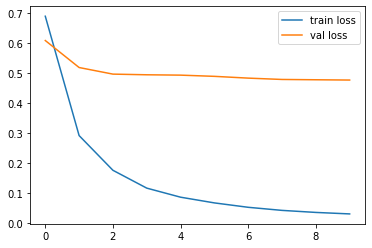

In [21]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model 2 - Accuracy plot

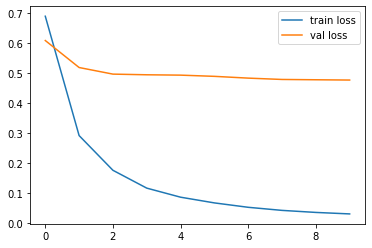

In [22]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

#Inception v3

Model 3: Perform Transfer Learning with Augmentation

Instantiating Inception v3 pretrained model

In [23]:
# input_shape = dimension of image + 3(3 colored channels - depth of the image)
# weights = use the weights from the VGG16 that were trained on imagenet dataset
# include_top = False (give the weights for stage1 not stage2)
ptm = PretrainedModel_inception(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

# To freeze the weights extracted above from VGG 
# freeze pretrained model weights
ptm.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


Model definition



In [24]:
# map the data into feature vectors
#Stage1
K = len(folders) # number of classes

#Stage2
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

# Model object
# inputs - goes in the pretrained model input
# output - comes out the entire model from stage2
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

Creating ImageDataGenerator

In [25]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input_inception  # make sure that the images confirm to Inception convolution model(stage1)
)

#Augementation is done only on train dataset but the test dataset should be transformed as per Inception stage1 requirements
gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input_inception
)

batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Model compilation and fit

In [26]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
4/4 [==============================] - 15s 3s/step - loss: 2.8816 - accuracy: 0.5075 - val_loss: 1.8306 - val_accuracy: 0.5700
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 1.5482 - accuracy: 0.6225 - val_loss: 0.6001 - val_accuracy: 0.7700
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 1.0378 - accuracy: 0.6950 - val_loss: 0.5263 - val_accuracy: 0.7950
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.6448 - accuracy: 0.7950 - val_loss: 0.7594 - val_accuracy: 0.7700
Epoch 5/10
4/4 [==============================] - 4s 1s/step - loss: 0.5125 - accuracy: 0.8350 - val_loss: 0.5514 - val_accuracy: 0.8200
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.5104 - accuracy: 0.8600 - val_loss: 0.5024 - val_accuracy: 0.8400
Epoch 7/10
4/4 [==============================] - 4s 1s/step - loss: 0.4338 - accuracy: 0.8675 - val_loss: 0.5359 - val_accuracy: 0.8100
Epoch 8/10
4/4 [========================

Model 3 - Loss plot

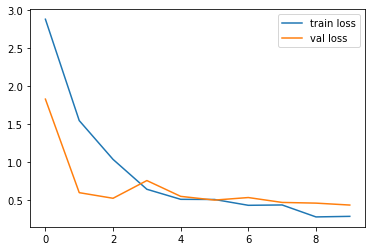

In [27]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model 3 - Accuracy plot

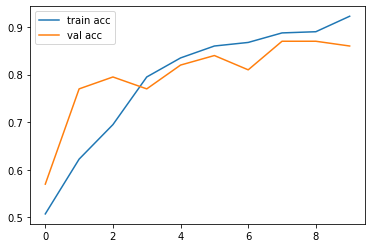

In [28]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**Model 4: Perform Transfer Learning without Augmentation**

Instantiating Inceptionv3 pretrained model

In [29]:
# input_shape = dimension of image + 3(3 colored channels - depth of the image)
# weights = use the weights from the VGG16 that were trained on imagenet dataset
# include_top = False (give the weights for stage1 not stage2)
ptm = PretrainedModel_inception(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

Model definition



In [30]:
# map the data into feature vectors
x = Flatten()(ptm.output)

# Model object
# inputs - goes in the pretrained model input
# output - comes out the entire model from stage2
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [31]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input_inception)

batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [32]:
# Creating a tabular dataset for all the image features - Take an image run it trhough stage1 and add it to feature vector matrix ony by one
# Each row representas an image in a vector form
# Number of training and testing images
Ntrain = len(image_files) #Gives the number of training images
Nvalid = len(valid_image_files) #Gives the number of test images

# Passing on the random input to know the size required by model
# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]  #Gives number of features per image (flattened dimensionality)

# Initialize with number of features per image
X_train = np.zeros((Ntrain, D)) #Ntrain nuumber of rows, D number of columns
Y_train = np.zeros(Ntrain)   #Ntrain number of rows for target values of each image
X_valid = np.zeros((Nvalid, D)) 
Y_valid = np.zeros(Nvalid)

In [33]:
# populate X_train and Y_train
i = 0  #which sample we are currently populating within the loop
for x, y in train_generator:   #Generate X and y tuples at each step (batch of images not one image) (128 in every batch except last one)
  # get features
  features = model.predict(x)  # predicting on each images of (128 total in batch)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)                  
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features        #Assign the features a 2dimensional array to X_train(128XD)
  Y_train[i:i + sz] = y               #Assign y to y_train (128)
  
  # increment i                      # incrementing by batch size (128)
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
400
breaking now
400


In [34]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
200


In [35]:
#Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

Model compilation and fit

In [36]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

linearmodel.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# fit the model
r = linearmodel.fit(
    X_train2, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid2, Y_valid),
)

Epoch 1/10
4/4 [==============================] - 1s 80ms/step - loss: 0.7080 - accuracy: 0.6475 - val_loss: 0.4533 - val_accuracy: 0.8200
Epoch 2/10
4/4 [==============================] - 0s 24ms/step - loss: 0.2906 - accuracy: 0.8700 - val_loss: 0.4978 - val_accuracy: 0.8250
Epoch 3/10
4/4 [==============================] - 0s 24ms/step - loss: 0.1785 - accuracy: 0.9325 - val_loss: 0.4895 - val_accuracy: 0.8450
Epoch 4/10
4/4 [==============================] - 0s 23ms/step - loss: 0.0880 - accuracy: 0.9625 - val_loss: 0.4768 - val_accuracy: 0.8550
Epoch 5/10
4/4 [==============================] - 0s 20ms/step - loss: 0.0588 - accuracy: 0.9850 - val_loss: 0.4589 - val_accuracy: 0.8550
Epoch 6/10
4/4 [==============================] - 0s 22ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.4583 - val_accuracy: 0.8350
Epoch 7/10
4/4 [==============================] - 0s 23ms/step - loss: 0.0355 - accuracy: 0.9925 - val_loss: 0.4630 - val_accuracy: 0.8400
Epoch 8/10
4/4 [===========

Model 4 - Loss plot

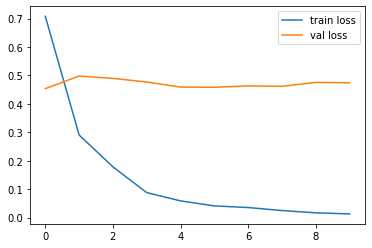

In [37]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model 4 - Accuracy plot

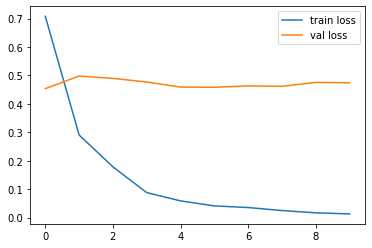

In [38]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

**Results**
* **Model1 (VGG16 with data augmentation)** gives training accuracy as 94% (0.51 loss) and validation accuracy as 87% (1.44 loss). Along with data augmentation it is compute expensive but generalize well on vlaidation dataset.

* **Model2 (VGG16 without data augmentation)** gives training accuracy as 99% (0.03 loss) and validation accuracy as 84% (0.47 loss). Without data augmentation it is not compute expensive and minimizes the training and validation loss but their is a considerable gap of 15% between training and validation accuracy in terms of generalization.

* **Model3 (Inceptionv3 with data augmentation)** gives training accuracy as 92% (0.28 loss) and validation accuracy as 86% (0.43 loss). Along with data augmentation it is compute expensive but generalize well on vlaidation dataset.

* **Model4 (Inceptionv3 without data augmentation)** gives training accuracy as 99% (0.01 loss) and validation accuracy as 84% (0.47 loss). Without data augmentation it is not compute expensive and minimizes training loss but doesn't generalize well on vlaidation dataset as their is a considerable gap of 15% in training and validation accuracy.

Overall model3 performs best.